In [33]:
# onedrive = r"C:\Users\Mike.Kryajak\OneDrive"
onedrive = r"C:\Users\mikek\OneDrive"
# %matplotlib ipympl
# %matplotlib qt
# %matplotlib widget
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray as xr
import xbout
import scipy
import re
import netCDF4 as nc
import matplotlib as mpl

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\gridtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))


# from gridtools.hypnotoad_tools import *
from gridtools.b2_tools import *
from gridtools.utils import *

from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from code_comparison.code_comparison import *
from code_comparison.viewer_2d import *

import gridtools.solps_python_scripts.setup
from gridtools.solps_python_scripts.plot_solps       import plot_1d, plot_2d, plot_wall_loads
from gridtools.solps_python_scripts.read_ft44 import read_ft44
import ipywidgets as widgets

%load_ext autoreload
%autoreload 2


print("Done")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done


In [6]:
from solps_python_scripts.utilities.units import units
from solps_python_scripts.utilities.names import name
from solps_python_scripts.utilities.last10s import read_last10s
from solps_python_scripts.utilities.plotting import make_ticks, triplot, to_triangles
from solps_python_scripts.utilities.accessories import load_pickle, find_sp44, populate_b2, compute_integral
from solps_python_scripts.utilities.accessories import rearrange_quadrangles, rearrange_triangles

from solps_python_scripts.read_b2mn import read_b2mn
from solps_python_scripts.read_b2fgmtry import read_b2fgmtry
from solps_python_scripts.read_b2fstate import read_b2fstate
from solps_python_scripts.read_b2fplasmf import read_b2fplasmf
from solps_python_scripts.read_ft44 import read_ft44
from solps_python_scripts.read_ft46 import read_ft46
from solps_python_scripts.read_triangle_mesh import read_triangle_mesh

from solps_python_scripts.reactions.compute_rates import compute_rates

In [2]:
path = os.path.join(onedrive_path, r"Project\collab\tech\compare_data\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16")

In [8]:
bal = nc.Dataset(os.path.join(path, "balance.nc"))
g = read_b2fgmtry(where=path)

b2fgmtry loaded from .pkl


In [35]:
btot = g["bb"][:,:,3]
bx = g["bb"][:,:,0]

# p = SOLPS

In [54]:
p = SOLPSplot(path, (btot/abs(bx)).transpose()[:, ::-1])

b2fgmtry loaded from .pkl


In [47]:
(btot/abs(bx)).max()

63.00192762477471

In [41]:
plt.close("all")

In [40]:
%matplotlib inline

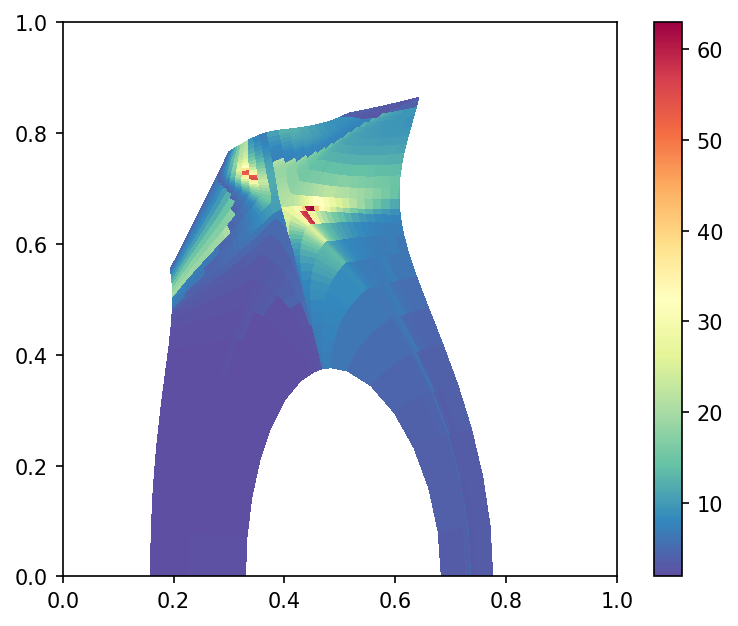

In [55]:
p.plot()

In [24]:

# ax
where = path
what = "fhix"
vmin = -6
vmax = 6
cmap = "Spectral_r"
scale = "linear"
labels = "None",
top = 0
bottom = None
right = None
left = None
mask = True
variation = False
save = False,
xgc1 = False
is_usn = False
plot_TF_coil = False
plot_wall = False
plot_cbar = True

b2fgmtry loaded from .pkl
b2fstate loaded from .pkl
b2fplasmf loaded from .pkl
fort.44 loaded from .pkl
fort.46 loaded from .pkl
Unit of fhix currently missing! Add it yourself in units.py :)
Unit of fhix currently missing! Add it yourself in units.py :)
Triplot triggered
-6 6
Norm: <matplotlib.colors.Normalize object at 0x000002224F13E4D0>
Cbar triggered
Unit of fhix None currently missing! Add it yourself in units.py :)


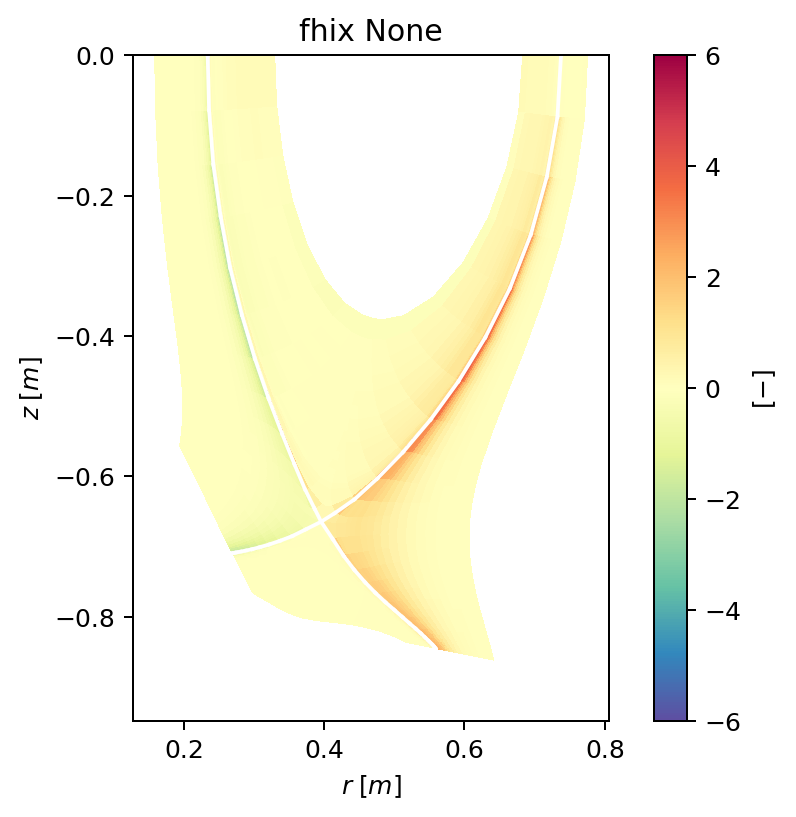

In [25]:

fig, ax = plt.subplots(dpi = 180)

if not isinstance(where, list):
    if variation is True:
        raise ValueError('where must be a list if variation is True.')
    else:
        where = [where]
if not isinstance(what, list):  what  = [what]
if not isinstance(vmin, list):  vmin  = [vmin]
if not isinstance(vmax, list):  vmax  = [vmax]

for j in range(len(what)):

    for i in range(len(where)):

        here = where[i]
        try: this = what[j]
        except: this = what[0]
        try: low = vmin[j]
        except: low = vmin[0]
        try: up = vmax[j]
        except: up = vmax[0]

        b2mn = read_b2mn(where = here)
        b2fgmtry = read_b2fgmtry(where = here, save = True)
        b2fstate = read_b2fstate(where = here, save = True)

        try:
            b2fplasmf = read_b2fplasmf(where = here, save = True)
        except:
            print()
            print('NO b2fplasmf > b2fstate used instead')
            print()
            b2fplasmf = b2fstate

        fort44 = {}
        fort46 = {}

        if b2mn['b2mndr_eirene'] == 1: 

            [neut, wld] = read_ft44(where = here, save = True)
            fort44['neut'] = neut
            fort44['wld']  = wld

            fort46 = read_ft46(where = here, save = True)
        
        try: 
            (sp, value) = populate_b2(what = this, b2mn = b2mn, b2fstate = b2fstate, b2fplasmf = b2fplasmf, fort44 = fort44)
            is_b2 = True
        except:
            try: value = fort46[this]
            except: raise ValueError(this + ' does NOT exist :(')
            sp = find_sp44(what = this, fort44 = fort44)
            is_b2 = False
            
        #########################################################
        value = value / (g["hz"] * g["hy"]) * 1e-6
        #########################################################
        
        if is_usn is True and is_b2 is True: value = value[::-1,:]
        
        try:    nsp = value.shape[2]
        except: nsp = 1

        if   units(of = this) == 'W \\rightarrow W \\cdot m^{-3}':
            vol = b2fgmtry['vol']
            value = divide_by_vol(values = value, vol = vol)
        elif units(of = this) == 'A \\rightarrow m^{-3}':
            value = divide_by_e(values = value)

        if xgc1 is True and is_b2:
            import h5py
            ext = '_b2'
            f = h5py.File(os.path.join(here, 'cells' + ext + '_quadx.hdf5'), 'w')
            dset = f.create_dataset('cells' + ext, data = b2fgmtry['crx'])
            f.close()
            f = h5py.File(os.path.join(here, 'cells' + ext + '_quady.hdf5'), 'w')
            dset = f.create_dataset('nodes' + ext, data = b2fgmtry['cry'])
            f.close()
            f = h5py.File(os.path.join(here, this + ext + '.hdf5'), 'w')
            dset = f.create_dataset(this + ext, data = value)
            f.close()

        if is_b2 is True:
            (value, nodes, cells) = to_triangles(nsp = nsp, vs = value, b2fgmtry = b2fgmtry)
        else:
            triangles = read_triangle_mesh(where = here, verbose = False, save = False)
            cells = triangles['cells']
            nodes = triangles['nodes']

        if xgc1 and not is_b2:
            import h5py
            ext = '_eir'
            f = h5py.File(os.path.join(here, 'cells' + ext + '.hdf5'), 'w')
            dset = f.create_dataset('cells' + ext, data = cells)
            f.close()
            f = h5py.File(os.path.join(here, 'nodes' + ext + '.hdf5'), 'w')
            dset = f.create_dataset('nodes' + ext, data = nodes)
            f.close()
            f = h5py.File(os.path.join(here, this + ext + '.hdf5'), 'w')
            dset = f.create_dataset(this + ext, data = value)
            f.close()

        if variation is True:
            if i == 0: cases = np.zeros((value.shape[0], len(where)))
            try:
                if value.shape[1] > 1:
                    raise ValueError('variation for multiple species not implemented yet.')
                cases[:,i] = value[:,0]
            except IndexError:
                cases[:,i] = value

        else:

            if this == "ti" or "tot" in this: sp = [""]

            if labels is not None: this += " " + labels[i]
            
            triplot(fig, ax, where = here, what = this, value = value, sp = sp, nodes = nodes, cells = cells,
                    vmin = low, vmax = up, cmap = cmap, scale = scale, top = top, bottom = bottom,
                    right = right, left = left, mask = mask, save = save, plot_cbar = plot_cbar)

In [22]:
value.shape

(7920,)

b2fgmtry loaded from .pkl
b2fstate loaded from .pkl
b2fplasmf loaded from .pkl
fort.44 loaded from .pkl
fort.46 loaded from .pkl
Unit of fhix currently missing! Add it yourself in units.py :)
Unit of fhix currently missing! Add it yourself in units.py :)
Triplot triggered
-26117.503404491 31081.780775882
Norm: <matplotlib.colors.SymLogNorm object at 0x00000183B8E03DF0>
Cbar triggered
Unit of fhix currently missing! Add it yourself in units.py :)


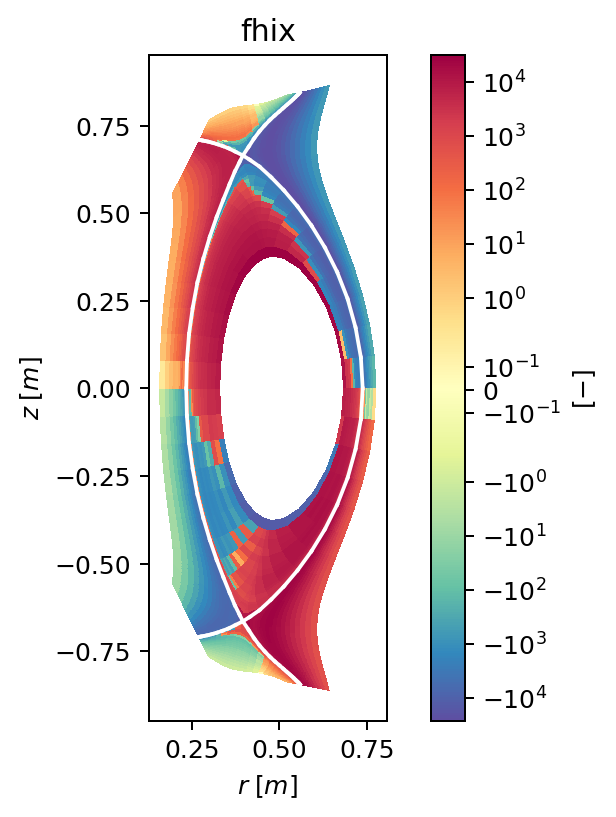

In [63]:
fig, ax = plt.subplots(dpi = 180)

cmap = "Spectral_r"
logscale = True
vmin = None
vmax = None
solps_cbar = True

plot_2d(fig, ax, 
        where = path, 
        what = "fhix", 
        cmap = cmap, 
        scale = ("log" if logscale is True else "linear"), 
        vmin = vmin, 
        vmax = vmax, 
        plot_cbar = solps_cbar)

In [17]:
bal.variables.keys()

dict_keys(['crx', 'cry', 'bb', 'hx', 'hy', 'hz', 'vol', 'gs', 'am', 'mp', 'ev', 'leftix', 'leftiy', 'rightix', 'rightiy', 'topix', 'topiy', 'bottomix', 'bottomiy', 'jxi', 'jxa', 'jsep', 'species', 'b2mndr_eirene', 'b2mndr_hz', 'za', 'fna_pinch', 'fna_pll', 'fna_drift', 'fna_ch', 'fna_nanom', 'fna_panom', 'fna_pschused', 'fna_tot', 'b2stbr_phys_sna_bal', 'b2stbr_bas_sna_bal', 'b2stbr_first_flight_sna_bal', 'b2stbc_sna_bal', 'b2stbm_sna_bal', 'ext_sna_bal', 'b2stel_sna_ion_bal', 'b2stel_sna_rec_bal', 'b2stcx_sna_bal', 'b2srsm_sna_bal', 'b2srdt_sna_bal', 'b2srst_sna_bal', 'tot_sna_bal', 'resco', 'fmo_flua', 'fmo_cvsa', 'fmo_hybr', 'fmo_b2nxfv', 'fmo_tot', 'b2stbr_phys_smo_bal', 'b2stbr_bas_smo_bal', 'b2stbc_smo_bal', 'b2stbm_smo_bal', 'ext_smo_bal', 'b2stel_smq_ion_bal', 'b2stel_smq_rec_bal', 'b2stcx_smq_bal', 'b2srsm_smo_bal', 'b2srdt_smo_bal', 'b2srst_smo_bal', 'b2sifr_smoch_bal', 'b2sifr_smotf_ehxp_bal', 'b2sifr_smotf_cthe_bal', 'b2sifr_smotf_cthi_bal', 'b2sifr_smofrea_bal', 'b2sifr_sm

In [7]:
crx = bal["crx"]
cry = bal["cry"]

# Following SOLPS convention: X poloidal, Y radial
Nx = crx.shape[2]
Ny = crx.shape[1]


In [8]:
i = 0
j = 0
idx = [np.array([0, 1, 3, 2, 0])]

np.concatenate([cry[:,i,j][tuple(idx)], crx[:,i,j][tuple(idx)]]).reshape(2,5).T

masked_array(
  data=[[-0.76572192,  0.29782674],
        [-0.76572419,  0.29783023],
        [-0.76564525,  0.29779026],
        [-0.76564298,  0.29778677],
        [-0.76572192,  0.29782674]],
  mask=False,
  fill_value=1e+20)

In [9]:
# In hermes-3 and needed for plot: lower left, lower right, upper right, upper left, lower left
# SOLPS crx structure: lower left, lower right, upper left, upper right
# So translating crx is gonna be 0, 1, 3, 2, 0
# crx is [corner, Y(radial), X(poloidal)]
idx = [np.array([0, 1, 3, 2, 0])]

patches = []
for i in range(Nx):
    for j in range(Ny):
        p = mpl.patches.Polygon(
            np.concatenate([crx[:,j,i][tuple(idx)], cry[:,j,i][tuple(idx)]]).reshape(2,5).T,
            
            fill=False,
            closed=True,
        )
        patches.append(p)

In [43]:
class SOLPSplot():
    """ 
    Wrapper for plotting SOLPS data from a balance file
    """
    def __init__(self, path, param):
        bal = nc.Dataset(os.path.join(path, "balance.nc"))
        g = read_b2fgmtry(where=path)
        
        
        # In hermes-3 and needed for plot: lower left, lower right, upper right, upper left, lower left
        # SOLPS crx structure: lower left, lower right, upper left, upper right
        # So translating crx is gonna be 0, 1, 3, 2, 0
        # crx is [corner, Y(radial), X(poloidal)]
        idx = [np.array([0, 1, 3, 2, 0])]

        # Make polygons
        patches = []
        for i in range(Nx):
            for j in range(Ny):
                p = mpl.patches.Polygon(
                    np.concatenate([crx[:,j,i][tuple(idx)], cry[:,j,i][tuple(idx)]]).reshape(2,5).T,
                    
                    fill=False,
                    closed=True,
                )
                patches.append(p)
                
        # Get data
        self.data = bal[param][:].data
        self.min = self.data.min()
        self.max = self.data.max()
        self.variables = bal.variables
        

    def plot(self, 
             ax = None,
             fig = None,
             norm = None, 
             cmap = "Spectral_r",
             antialias = False,
             linecolor = "k",
             linewidth = 0,
             vmin = None,
             vmax = None,
             logscale = False):
        
        if vmin == None:
            vmin = self.min
        if vmax == None:
            vmax = self.max
        if norm == None:
            norm = xbout.plotting.utils._create_norm(logscale, norm, vmin, vmax)
        if ax == None:
            fig, ax = plt.subplots(dpi = 150)
            

        logscale = False


        cmap = "Spectral_r"

        # Polygon colors
        
        colors = self.data.transpose().flatten()
        polys = mpl.collections.PatchCollection(
            patches, alpha = 1, norm = norm, cmap = cmap, 
            antialiaseds = antialias,
            edgecolors = linecolor,
            linewidths = linewidth,
            joinstyle = "bevel")

        polys.set_array(colors)
        
        fig.colorbar(polys)
        ax.add_collection(polys)
        ax.set_aspect("equal")
                

        

In [46]:
d

dict_keys(['crx', 'cry', 'bb', 'hx', 'hy', 'hz', 'vol', 'gs', 'am', 'mp', 'ev', 'leftix', 'leftiy', 'rightix', 'rightiy', 'topix', 'topiy', 'bottomix', 'bottomiy', 'jxi', 'jxa', 'jsep', 'species', 'b2mndr_eirene', 'b2mndr_hz', 'za', 'fna_pinch', 'fna_pll', 'fna_drift', 'fna_ch', 'fna_nanom', 'fna_panom', 'fna_pschused', 'fna_tot', 'b2stbr_phys_sna_bal', 'b2stbr_bas_sna_bal', 'b2stbr_first_flight_sna_bal', 'b2stbc_sna_bal', 'b2stbm_sna_bal', 'ext_sna_bal', 'b2stel_sna_ion_bal', 'b2stel_sna_rec_bal', 'b2stcx_sna_bal', 'b2srsm_sna_bal', 'b2srdt_sna_bal', 'b2srst_sna_bal', 'tot_sna_bal', 'resco', 'fmo_flua', 'fmo_cvsa', 'fmo_hybr', 'fmo_b2nxfv', 'fmo_tot', 'b2stbr_phys_smo_bal', 'b2stbr_bas_smo_bal', 'b2stbc_smo_bal', 'b2stbm_smo_bal', 'ext_smo_bal', 'b2stel_smq_ion_bal', 'b2stel_smq_rec_bal', 'b2stcx_smq_bal', 'b2srsm_smo_bal', 'b2srdt_smo_bal', 'b2srst_smo_bal', 'b2sifr_smoch_bal', 'b2sifr_smotf_ehxp_bal', 'b2sifr_smotf_cthe_bal', 'b2sifr_smotf_cthi_bal', 'b2sifr_smofrea_bal', 'b2sifr_sm

b2fgmtry loaded from .pkl


C:\Users\Mike.Kryajak\AppData\Local\Temp\ipykernel_29672\1897350978.py:74: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(polys)


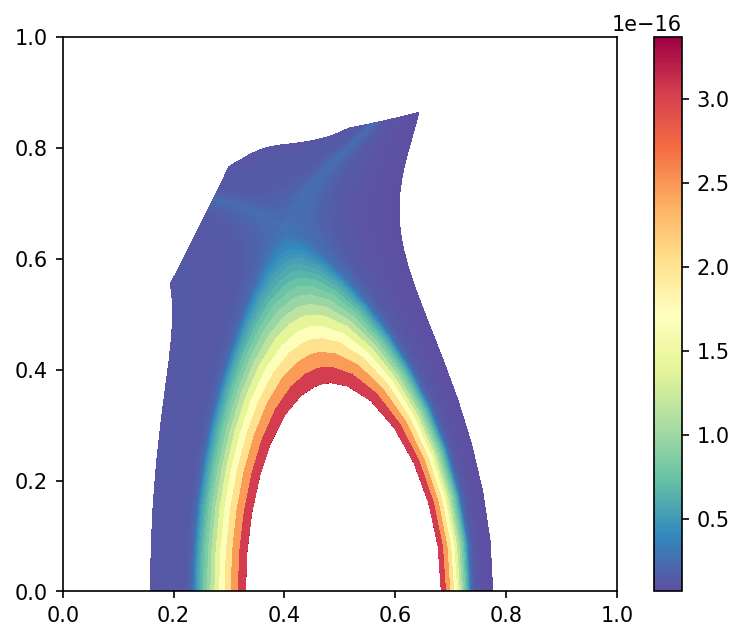

In [44]:
p = SOLPSplot(path, "ti")
p.plot()

In [48]:
[print(x) for x in bal.variables.keys()]

crx
cry
bb
hx
hy
hz
vol
gs
am
mp
ev
leftix
leftiy
rightix
rightiy
topix
topiy
bottomix
bottomiy
jxi
jxa
jsep
species
b2mndr_eirene
b2mndr_hz
za
fna_pinch
fna_pll
fna_drift
fna_ch
fna_nanom
fna_panom
fna_pschused
fna_tot
b2stbr_phys_sna_bal
b2stbr_bas_sna_bal
b2stbr_first_flight_sna_bal
b2stbc_sna_bal
b2stbm_sna_bal
ext_sna_bal
b2stel_sna_ion_bal
b2stel_sna_rec_bal
b2stcx_sna_bal
b2srsm_sna_bal
b2srdt_sna_bal
b2srst_sna_bal
tot_sna_bal
resco
fmo_flua
fmo_cvsa
fmo_hybr
fmo_b2nxfv
fmo_tot
b2stbr_phys_smo_bal
b2stbr_bas_smo_bal
b2stbc_smo_bal
b2stbm_smo_bal
ext_smo_bal
b2stel_smq_ion_bal
b2stel_smq_rec_bal
b2stcx_smq_bal
b2srsm_smo_bal
b2srdt_smo_bal
b2srst_smo_bal
b2sifr_smoch_bal
b2sifr_smotf_ehxp_bal
b2sifr_smotf_cthe_bal
b2sifr_smotf_cthi_bal
b2sifr_smofrea_bal
b2sifr_smofria_bal
b2sifr_smotfea_bal
b2sifr_smotfia_bal
b2siav_smovh_bal
b2siav_smovv_bal
b2sicf_smo_bal
b2sian_smo_bal
b2nxdv_smo_bal
b2sigp_smogp_bal
b2sigp_smogpi_bal
b2sigp_smogpe_bal
b2sigp_smogpgr_bal
b2sigp_pstat_bal
b2s

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [49]:
bal["eirene_mc_papl_sna_bal"]

<class 'netCDF4._netCDF4.Variable'>
float64 eirene_mc_papl_sna_bal(nstra, ns, ny_plus2, nx_plus2)
unlimited dimensions: 
current shape = (14, 2, 38, 112)
filling on, default _FillValue of 9.969209968386869e+36 used

C:\Users\Mike.Kryajak\AppData\Local\Temp\ipykernel_29672\2678596938.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(polys)


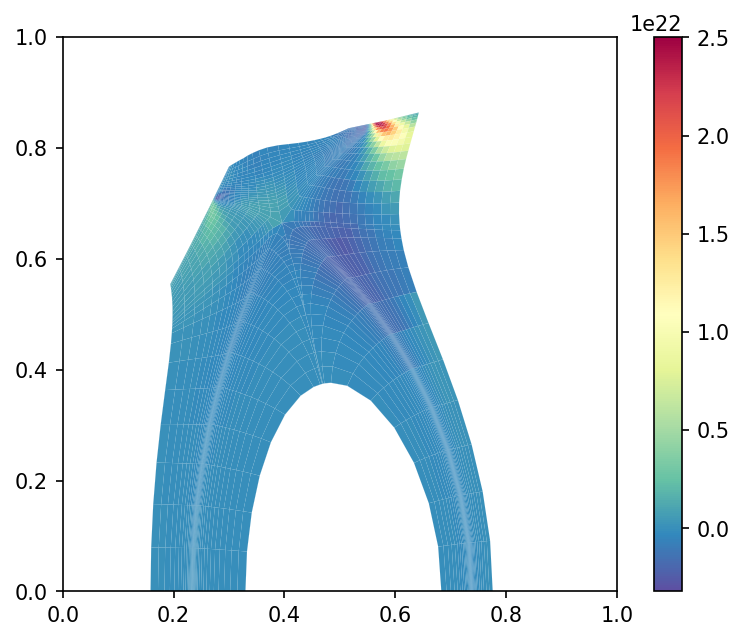

In [20]:
param = "rfluxa"
data = bal[param][:].data

logscale = False
vmin = data.min()
vmax = data.max()
norm = None
antialias = True
linecolour = "k"
linewidth = 0
cmap = "Spectral_r"

# vmin = 1
# vmax = 100

norm = xbout.plotting.utils._create_norm(logscale, norm, vmin, vmax)

colors = data.transpose().flatten()
polys = mpl.collections.PatchCollection(
    patches, alpha = 1, norm = norm, cmap = cmap, 
    antialiaseds = antialias,
    edgecolors = linecolour,
    linewidths = linewidth,
    joinstyle = "bevel")

polys.set_array(colors)

fig, ax = plt.subplots(dpi = 150)
fig.colorbar(polys)

ax.add_collection(polys)
ax.set_aspect("equal")

In [12]:
data

array([[[1.44592638e+17, 1.44592638e+17, 1.42928918e+17, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.44592638e+17, 1.44592638e+17, 1.42928918e+17, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.34123109e+17, 1.34123109e+17, 1.24371122e+17, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [5.38789744e+16, 5.38789744e+16, 5.33356460e+16, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.66583187e+16, 4.66583187e+16, 4.55631627e+16, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.66583187e+16, 4.66583187e+16, 4.55631627e+16, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]])

In [7]:
[print(x) for x in bal.variables.keys()]

crx
cry
bb
hx
hy
hz
vol
gs
am
mp
ev
leftix
leftiy
rightix
rightiy
topix
topiy
bottomix
bottomiy
jxi
jxa
jsep
species
b2mndr_eirene
b2mndr_hz
za
fna_pinch
fna_pll
fna_drift
fna_ch
fna_nanom
fna_panom
fna_pschused
fna_tot
b2stbr_phys_sna_bal
b2stbr_bas_sna_bal
b2stbr_first_flight_sna_bal
b2stbc_sna_bal
b2stbm_sna_bal
ext_sna_bal
b2stel_sna_ion_bal
b2stel_sna_rec_bal
b2stcx_sna_bal
b2srsm_sna_bal
b2srdt_sna_bal
b2srst_sna_bal
tot_sna_bal
resco
fmo_flua
fmo_cvsa
fmo_hybr
fmo_b2nxfv
fmo_tot
b2stbr_phys_smo_bal
b2stbr_bas_smo_bal
b2stbc_smo_bal
b2stbm_smo_bal
ext_smo_bal
b2stel_smq_ion_bal
b2stel_smq_rec_bal
b2stcx_smq_bal
b2srsm_smo_bal
b2srdt_smo_bal
b2srst_smo_bal
b2sifr_smoch_bal
b2sifr_smotf_ehxp_bal
b2sifr_smotf_cthe_bal
b2sifr_smotf_cthi_bal
b2sifr_smofrea_bal
b2sifr_smofria_bal
b2sifr_smotfea_bal
b2sifr_smotfia_bal
b2siav_smovh_bal
b2siav_smovv_bal
b2sicf_smo_bal
b2sian_smo_bal
b2nxdv_smo_bal
b2sigp_smogp_bal
b2sigp_smogpi_bal
b2sigp_smogpe_bal
b2sigp_smogpgr_bal
b2sigp_pstat_bal
b2s

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,